In [ ]:
import torch.nn as nn
import torch
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

#part-1


In [ ]:
import torch.nn as nn
import torch
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # adjust_learning_rate(optimizer, epoch, epochs, lr)
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results
def plot_loss_curves(results):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

#Train


In [ ]:
data_transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               ])

In [ ]:
train_data=datasets.CIFAR100("/content/",download=True,transform=data_transform)
test_data=datasets.CIFAR100("/content/",train=False,download=True,transform=data_transform)

100%|██████████| 169001437/169001437 [00:13<00:00, 12947095.93it/s]


Extracting /content/cifar-100-python.tar.gz to /content/
Files already downloaded and verified


In [ ]:
class CNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*16*16,
                    out_features=output_shape)
      )
  def forward(self,x):
    x = self.conv_block_1(x)

    x = self.classifier(x)
    # print(x.shape)
    return x

In [ ]:
class V2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [ ]:
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, num_classes=100):
        super(TinyVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
BATCH_SIZE=32
train_dataloader=DataLoader(train_data,batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=TinyVGG(len(train_data.classes)).to(device)
try:
  import torchinfo
except:
  !pip install torchinfo
from torchinfo import summary
summary(model0,(32,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 100]                 --
├─Sequential: 1-1                        [32, 64, 8, 8]            --
│    └─Conv2d: 2-1                       [32, 32, 32, 32]          896
│    └─ReLU: 2-2                         [32, 32, 32, 32]          --
│    └─Conv2d: 2-3                       [32, 32, 32, 32]          9,248
│    └─ReLU: 2-4                         [32, 32, 32, 32]          --
│    └─MaxPool2d: 2-5                    [32, 32, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 64, 16, 16]          18,496
│    └─ReLU: 2-7                         [32, 64, 16, 16]          --
│    └─Conv2d: 2-8                       [32, 64, 16, 16]          36,928
│    └─ReLU: 2-9                         [32, 64, 16, 16]          --
│    └─MaxPool2d: 2-10                   [32, 64, 8, 8]            --
├─AdaptiveAvgPool2d: 1-2                 [32, 64, 4, 4]            --
├─S

In [ ]:
from timeit import default_timer as timer
import numpy as np
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=TinyVGG(len(train_data.classes)).to(device)
start_time = timer()
lr=0.1
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
loss_fn=nn.CrossEntropyLoss()
results=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1300 | train_acc: 0.2018 | test_loss: 1.8220 | test_acc: 0.3210
Epoch: 2 | train_loss: 1.6984 | train_acc: 0.3788 | test_loss: 1.4586 | test_acc: 0.4682
Epoch: 3 | train_loss: 1.4034 | train_acc: 0.4910 | test_loss: 1.3407 | test_acc: 0.5215
Epoch: 4 | train_loss: 1.2005 | train_acc: 0.5723 | test_loss: 1.0390 | test_acc: 0.6342
Epoch: 5 | train_loss: 1.0346 | train_acc: 0.6365 | test_loss: 0.9165 | test_acc: 0.6804
Epoch: 6 | train_loss: 0.9093 | train_acc: 0.6803 | test_loss: 0.8434 | test_acc: 0.7054
Epoch: 7 | train_loss: 0.8165 | train_acc: 0.7169 | test_loss: 0.8135 | test_acc: 0.7177
Epoch: 8 | train_loss: 0.7474 | train_acc: 0.7425 | test_loss: 0.8537 | test_acc: 0.7063
Epoch: 9 | train_loss: 0.6859 | train_acc: 0.7605 | test_loss: 0.8046 | test_acc: 0.7180
Epoch: 10 | train_loss: 0.6371 | train_acc: 0.7752 | test_loss: 0.7638 | test_acc: 0.7319
Epoch: 11 | train_loss: 0.5966 | train_acc: 0.7924 | test_loss: 0.7976 | test_acc: 0.7318
Epoch: 12 | train_l

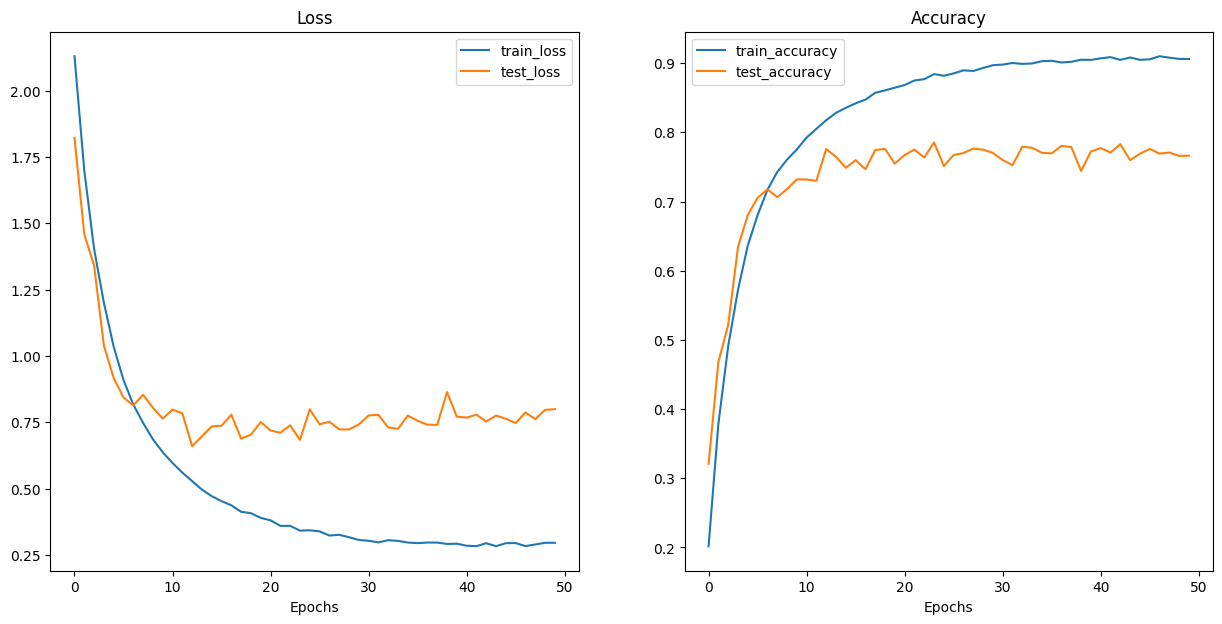

In [ ]:
plot_loss_curves(results)
import json

with open("tinyvgg100.json", "w") as outfile:
  json.dump(results, outfile)

In [ ]:
from timeit import default_timer as timer
import numpy as np
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=TinyVGG(len(train_data.classes)).to(device)
start_time = timer()
lr=0.1
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
loss_fn=nn.CrossEntropyLoss()
results=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6062 | train_acc: 0.0098 | test_loss: 4.5968 | test_acc: 0.0124
Epoch: 2 | train_loss: 4.2959 | train_acc: 0.0411 | test_loss: 4.0501 | test_acc: 0.0759
Epoch: 3 | train_loss: 3.9533 | train_acc: 0.0851 | test_loss: 3.7901 | test_acc: 0.1154
Epoch: 4 | train_loss: 3.6782 | train_acc: 0.1262 | test_loss: 3.4157 | test_acc: 0.1801
Epoch: 5 | train_loss: 3.4290 | train_acc: 0.1722 | test_loss: 3.1856 | test_acc: 0.2283
Epoch: 6 | train_loss: 3.2129 | train_acc: 0.2118 | test_loss: 3.0454 | test_acc: 0.2569
Epoch: 7 | train_loss: 3.0355 | train_acc: 0.2452 | test_loss: 2.7870 | test_acc: 0.3053
Epoch: 8 | train_loss: 2.8950 | train_acc: 0.2709 | test_loss: 2.6765 | test_acc: 0.3252
Epoch: 9 | train_loss: 2.7680 | train_acc: 0.2986 | test_loss: 2.6366 | test_acc: 0.3296
Epoch: 10 | train_loss: 2.6657 | train_acc: 0.3159 | test_loss: 2.5294 | test_acc: 0.3565
Epoch: 11 | train_loss: 2.5765 | train_acc: 0.3384 | test_loss: 2.5154 | test_acc: 0.3633
Epoch: 12 | train_l

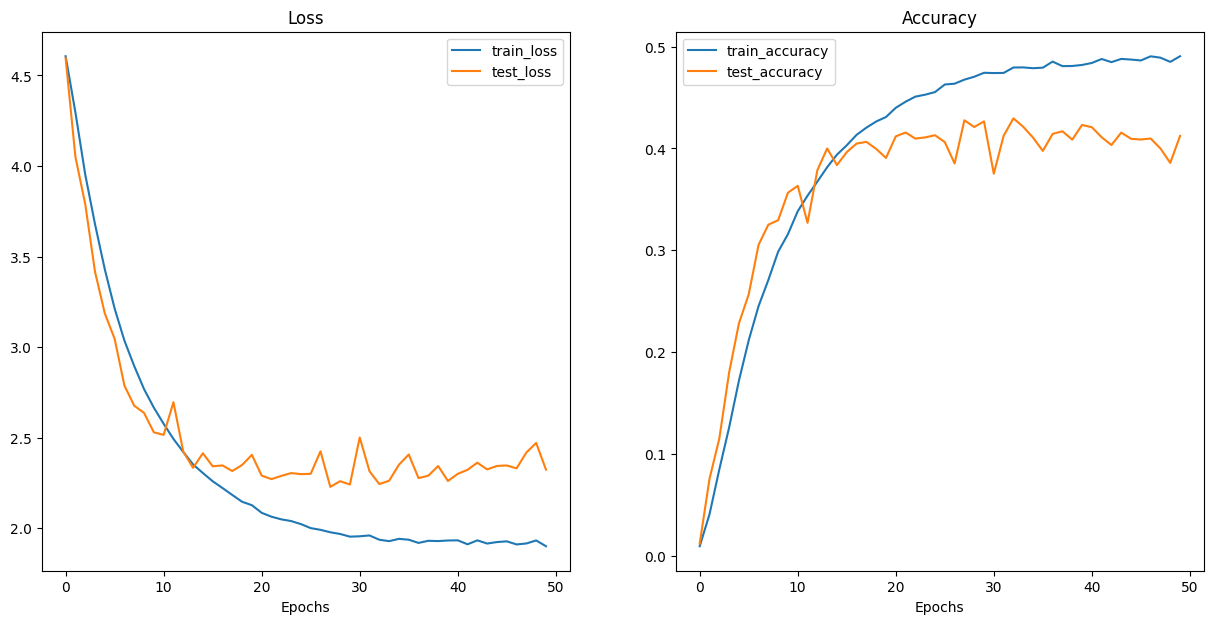

In [ ]:
plot_loss_curves(results)

In [ ]:
from timeit import default_timer as timer
import numpy as np
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=TinyVGG(len(train_data.classes)).to(device)
start_time = timer()
lr=0.1
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
loss_fn=nn.CrossEntropyLoss()
results=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.5900 | train_acc: 0.0124 | test_loss: 4.4109 | test_acc: 0.0356
Epoch: 2 | train_loss: 4.2355 | train_acc: 0.0499 | test_loss: 3.9268 | test_acc: 0.0894
Epoch: 3 | train_loss: 3.9312 | train_acc: 0.0870 | test_loss: 3.7271 | test_acc: 0.1150
Epoch: 4 | train_loss: 3.6565 | train_acc: 0.1315 | test_loss: 3.3618 | test_acc: 0.1866
Epoch: 5 | train_loss: 3.3965 | train_acc: 0.1769 | test_loss: 3.1632 | test_acc: 0.2287
Epoch: 6 | train_loss: 3.1821 | train_acc: 0.2183 | test_loss: 2.8904 | test_acc: 0.2861


KeyboardInterrupt: ignored

In [ ]:
from timeit import default_timer as timer
import numpy as np
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=V2(3,10,len(train_data.classes)).to(device)
start_time = timer()
lr=0.1
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
loss_fn=nn.CrossEntropyLoss()
results=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0828 | train_acc: 0.2286 | test_loss: 1.9015 | test_acc: 0.3821
Epoch: 2 | train_loss: 1.5614 | train_acc: 0.4429 | test_loss: 1.4959 | test_acc: 0.4706
Epoch: 3 | train_loss: 1.4050 | train_acc: 0.5047 | test_loss: 1.4103 | test_acc: 0.5006
Epoch: 4 | train_loss: 1.3346 | train_acc: 0.5294 | test_loss: 1.2919 | test_acc: 0.5466
Epoch: 5 | train_loss: 1.2970 | train_acc: 0.5436 | test_loss: 1.4798 | test_acc: 0.4900
Epoch: 6 | train_loss: 1.2505 | train_acc: 0.5598 | test_loss: 1.3500 | test_acc: 0.5199
Epoch: 7 | train_loss: 1.2248 | train_acc: 0.5680 | test_loss: 1.2881 | test_acc: 0.5566
Epoch: 8 | train_loss: 1.2103 | train_acc: 0.5730 | test_loss: 1.2648 | test_acc: 0.5645
Epoch: 9 | train_loss: 1.1884 | train_acc: 0.5820 | test_loss: 1.2869 | test_acc: 0.5480
Epoch: 10 | train_loss: 1.1753 | train_acc: 0.5853 | test_loss: 1.2316 | test_acc: 0.5690
Epoch: 11 | train_loss: 1.1657 | train_acc: 0.5914 | test_loss: 1.1812 | test_acc: 0.5935
Epoch: 12 | train_l

KeyboardInterrupt: ignored

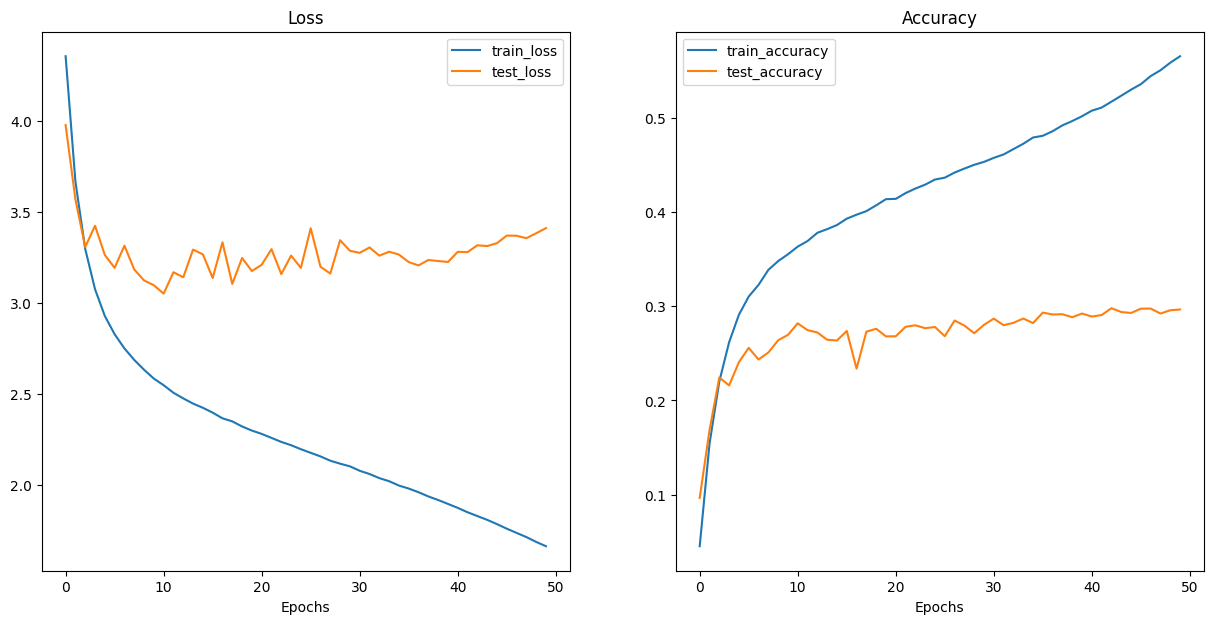

In [ ]:
plot_loss_curves(results)

In [ ]:
from timeit import default_timer as timer
import numpy as np
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=CNN(3,10,len(train_data.classes)).to(device)
start_time = timer()
lr=0.1
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
loss_fn=nn.CrossEntropyLoss()
results=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(results)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.9630 | train_acc: 0.1093 | test_loss: 3.7456 | test_acc: 0.1531
Epoch: 2 | train_loss: 3.3255 | train_acc: 0.2248 | test_loss: 3.2996 | test_acc: 0.2282
Epoch: 3 | train_loss: 2.9673 | train_acc: 0.2930 | test_loss: 3.3984 | test_acc: 0.2285
Epoch: 4 | train_loss: 2.6961 | train_acc: 0.3444 | test_loss: 3.1325 | test_acc: 0.2677
Epoch: 5 | train_loss: 2.4699 | train_acc: 0.3915 | test_loss: 3.5943 | test_acc: 0.2257
Epoch: 6 | train_loss: 2.2737 | train_acc: 0.4295 | test_loss: 3.5428 | test_acc: 0.2525
Epoch: 7 | train_loss: 2.1092 | train_acc: 0.4614 | test_loss: 3.5314 | test_acc: 0.2439
Epoch: 8 | train_loss: 1.9652 | train_acc: 0.4907 | test_loss: 3.6615 | test_acc: 0.2505
Epoch: 9 | train_loss: 1.8360 | train_acc: 0.5204 | test_loss: 4.0332 | test_acc: 0.2172
Epoch: 10 | train_loss: 1.7368 | train_acc: 0.5408 | test_loss: 3.9825 | test_acc: 0.2353
Epoch: 11 | train_loss: 1.6382 | train_acc: 0.5611 | test_loss: 4.5807 | test_acc: 0.2217
Epoch: 12 | train_l

KeyboardInterrupt: ignored

In [ ]:
from timeit import default_timer as timer
import numpy as np
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=CNN(3,10,len(train_data.classes)).to(device)
start_time = timer()
lr=0.1
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
loss_fn=nn.CrossEntropyLoss()
results=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

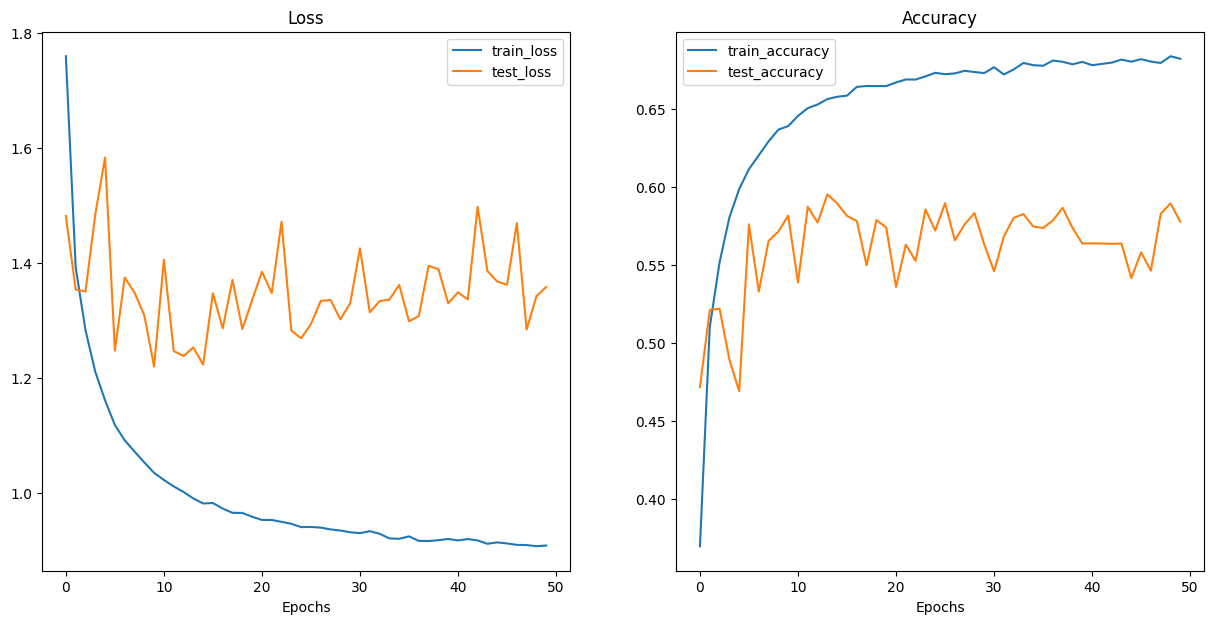

In [ ]:
plot_loss_curves(results)

In [ ]:
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=CNN(3,10,len(train_data.classes)).to(device)
from timeit import default_timer as timer
start_time = timer()
optimizer=torch.optim.SGD(model0.parameters(),lr=0.08)
loss_fn=nn.CrossEntropyLoss()
results1=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7927 | train_acc: 0.3596 | test_loss: 1.5892 | test_acc: 0.4246
Epoch: 2 | train_loss: 1.3921 | train_acc: 0.5056 | test_loss: 1.4314 | test_acc: 0.4888
Epoch: 3 | train_loss: 1.2630 | train_acc: 0.5595 | test_loss: 1.3199 | test_acc: 0.5401
Epoch: 4 | train_loss: 1.1884 | train_acc: 0.5880 | test_loss: 1.2808 | test_acc: 0.5605
Epoch: 5 | train_loss: 1.1432 | train_acc: 0.6046 | test_loss: 1.3158 | test_acc: 0.5458
Epoch: 6 | train_loss: 1.0964 | train_acc: 0.6204 | test_loss: 1.2401 | test_acc: 0.5765
Epoch: 7 | train_loss: 1.0656 | train_acc: 0.6309 | test_loss: 1.1738 | test_acc: 0.5920
Epoch: 8 | train_loss: 1.0369 | train_acc: 0.6418 | test_loss: 1.3066 | test_acc: 0.5536
Epoch: 9 | train_loss: 1.0196 | train_acc: 0.6496 | test_loss: 1.2735 | test_acc: 0.5609
Epoch: 10 | train_loss: 1.0061 | train_acc: 0.6523 | test_loss: 1.1969 | test_acc: 0.5908
Epoch: 11 | train_loss: 0.9901 | train_acc: 0.6572 | test_loss: 1.2510 | test_acc: 0.5859
Epoch: 12 | train_l

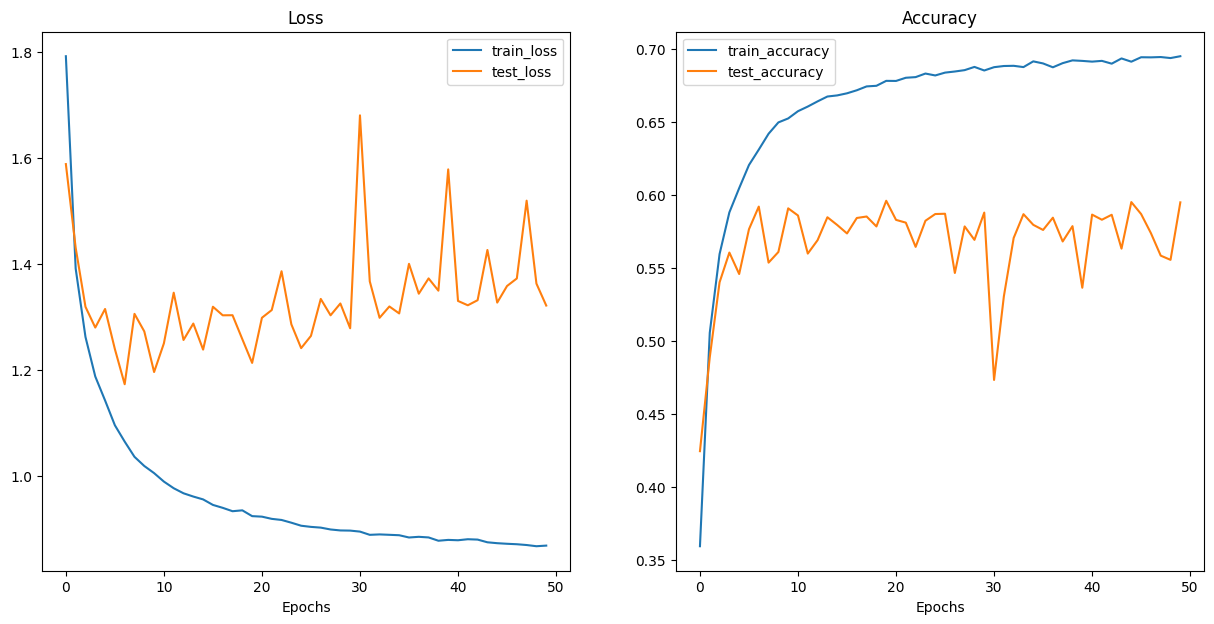

In [ ]:
plot_loss_curves(results1)

In [ ]:
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=CNN(3,10,len(train_data.classes)).to(device)
from timeit import default_timer as timer
start_time = timer()
optimizer=torch.optim.SGD(model0.parameters(),lr=0.06)
loss_fn=nn.CrossEntropyLoss()
results2=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7593 | train_acc: 0.3714 | test_loss: 1.4855 | test_acc: 0.4641
Epoch: 2 | train_loss: 1.3978 | train_acc: 0.5013 | test_loss: 1.3990 | test_acc: 0.4900
Epoch: 3 | train_loss: 1.2621 | train_acc: 0.5531 | test_loss: 1.2438 | test_acc: 0.5625
Epoch: 4 | train_loss: 1.1814 | train_acc: 0.5840 | test_loss: 1.3068 | test_acc: 0.5370
Epoch: 5 | train_loss: 1.1245 | train_acc: 0.6078 | test_loss: 1.2037 | test_acc: 0.5829
Epoch: 6 | train_loss: 1.0814 | train_acc: 0.6224 | test_loss: 1.1929 | test_acc: 0.5980
Epoch: 7 | train_loss: 1.0507 | train_acc: 0.6327 | test_loss: 1.2801 | test_acc: 0.5645
Epoch: 8 | train_loss: 1.0237 | train_acc: 0.6419 | test_loss: 1.1594 | test_acc: 0.5984
Epoch: 9 | train_loss: 1.0043 | train_acc: 0.6508 | test_loss: 1.3215 | test_acc: 0.5530
Epoch: 10 | train_loss: 0.9893 | train_acc: 0.6566 | test_loss: 1.1749 | test_acc: 0.6032
Epoch: 11 | train_loss: 0.9738 | train_acc: 0.6589 | test_loss: 1.2548 | test_acc: 0.5829
Epoch: 12 | train_l

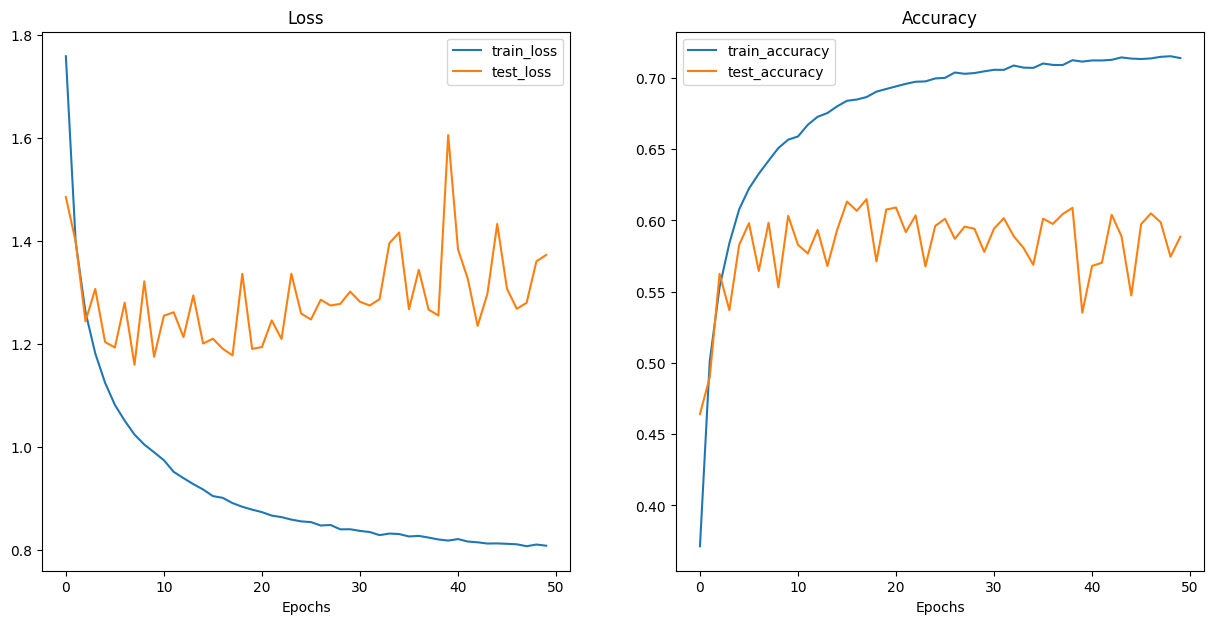

In [ ]:
plot_loss_curves(results2)

In [ ]:
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=CNN(3,10,len(train_data.classes)).to(device)
from timeit import default_timer as timer
start_time = timer()
optimizer=torch.optim.SGD(model0.parameters(),lr=0.04)
loss_fn=nn.CrossEntropyLoss()
results3=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7474 | train_acc: 0.3761 | test_loss: 1.4898 | test_acc: 0.4589
Epoch: 2 | train_loss: 1.4126 | train_acc: 0.4955 | test_loss: 1.3207 | test_acc: 0.5403
Epoch: 3 | train_loss: 1.2690 | train_acc: 0.5520 | test_loss: 1.2845 | test_acc: 0.5466
Epoch: 4 | train_loss: 1.1754 | train_acc: 0.5867 | test_loss: 1.2039 | test_acc: 0.5741
Epoch: 5 | train_loss: 1.1155 | train_acc: 0.6111 | test_loss: 1.1590 | test_acc: 0.5904
Epoch: 6 | train_loss: 1.0652 | train_acc: 0.6273 | test_loss: 1.1802 | test_acc: 0.5878
Epoch: 7 | train_loss: 1.0225 | train_acc: 0.6440 | test_loss: 1.4373 | test_acc: 0.5069
Epoch: 8 | train_loss: 0.9941 | train_acc: 0.6539 | test_loss: 1.1520 | test_acc: 0.6028
Epoch: 9 | train_loss: 0.9671 | train_acc: 0.6631 | test_loss: 1.2764 | test_acc: 0.5595
Epoch: 10 | train_loss: 0.9454 | train_acc: 0.6687 | test_loss: 1.2140 | test_acc: 0.5866
Epoch: 11 | train_loss: 0.9330 | train_acc: 0.6723 | test_loss: 1.1243 | test_acc: 0.6109
Epoch: 12 | train_l

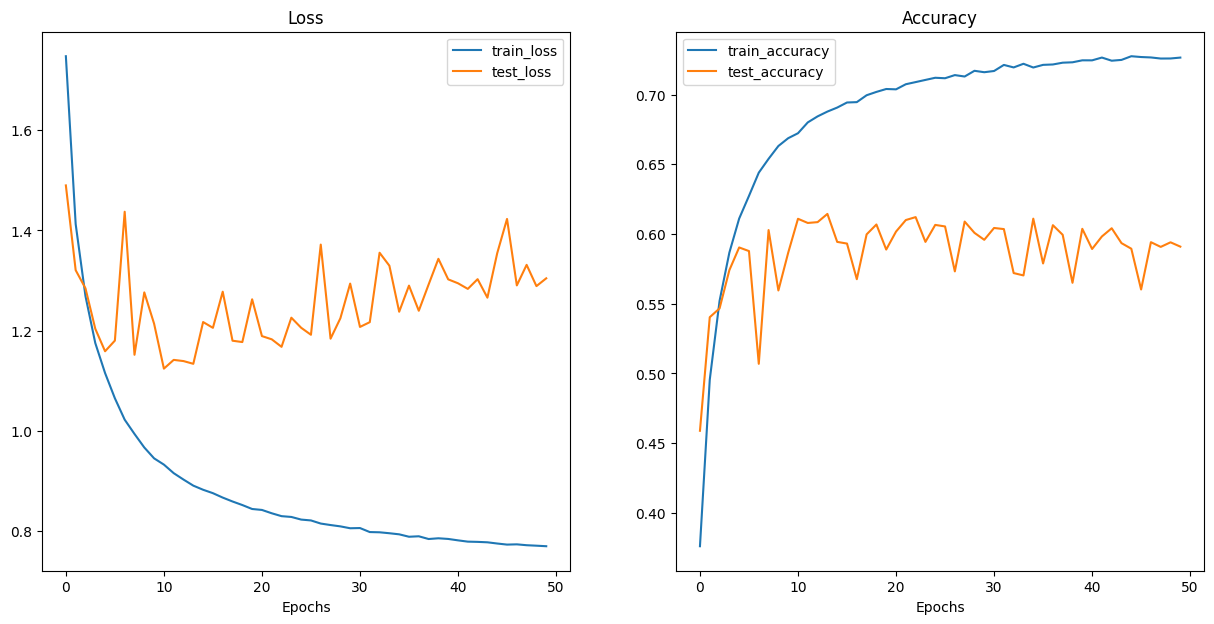

In [ ]:
plot_loss_curves(results3)

In [ ]:
import pickle
from pathlib import Path
# Path("results2.txt").touch()
filehandler = open("results2", 'wb')
pickle.dump(results2, filehandler)
# Path("results3.txt").touch()
filehandler = open("results3" ,'wb')
pickle.dump(results3, filehandler)

In [ ]:
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=CNN(3,10,len(train_data.classes)).to(device)
from timeit import default_timer as timer
start_time = timer()
optimizer=torch.optim.SGD(model0.parameters(),lr=0.02)
loss_fn=nn.CrossEntropyLoss()
results4=train(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8198 | train_acc: 0.3481 | test_loss: 1.6508 | test_acc: 0.4164
Epoch: 2 | train_loss: 1.5025 | train_acc: 0.4657 | test_loss: 1.4866 | test_acc: 0.4731
Epoch: 3 | train_loss: 1.3856 | train_acc: 0.5067 | test_loss: 1.4658 | test_acc: 0.4725
Epoch: 4 | train_loss: 1.2801 | train_acc: 0.5481 | test_loss: 1.2767 | test_acc: 0.5407
Epoch: 5 | train_loss: 1.2199 | train_acc: 0.5688 | test_loss: 1.2423 | test_acc: 0.5658
Epoch: 6 | train_loss: 1.1773 | train_acc: 0.5868 | test_loss: 1.2468 | test_acc: 0.5654
Epoch: 7 | train_loss: 1.1475 | train_acc: 0.5963 | test_loss: 1.3337 | test_acc: 0.5362
Epoch: 8 | train_loss: 1.1160 | train_acc: 0.6084 | test_loss: 1.1705 | test_acc: 0.5965
Epoch: 9 | train_loss: 1.0814 | train_acc: 0.6209 | test_loss: 1.2229 | test_acc: 0.5709
Epoch: 10 | train_loss: 1.0507 | train_acc: 0.6328 | test_loss: 1.1732 | test_acc: 0.5936
Epoch: 11 | train_loss: 1.0247 | train_acc: 0.6431 | test_loss: 1.1698 | test_acc: 0.5878
Epoch: 12 | train_l

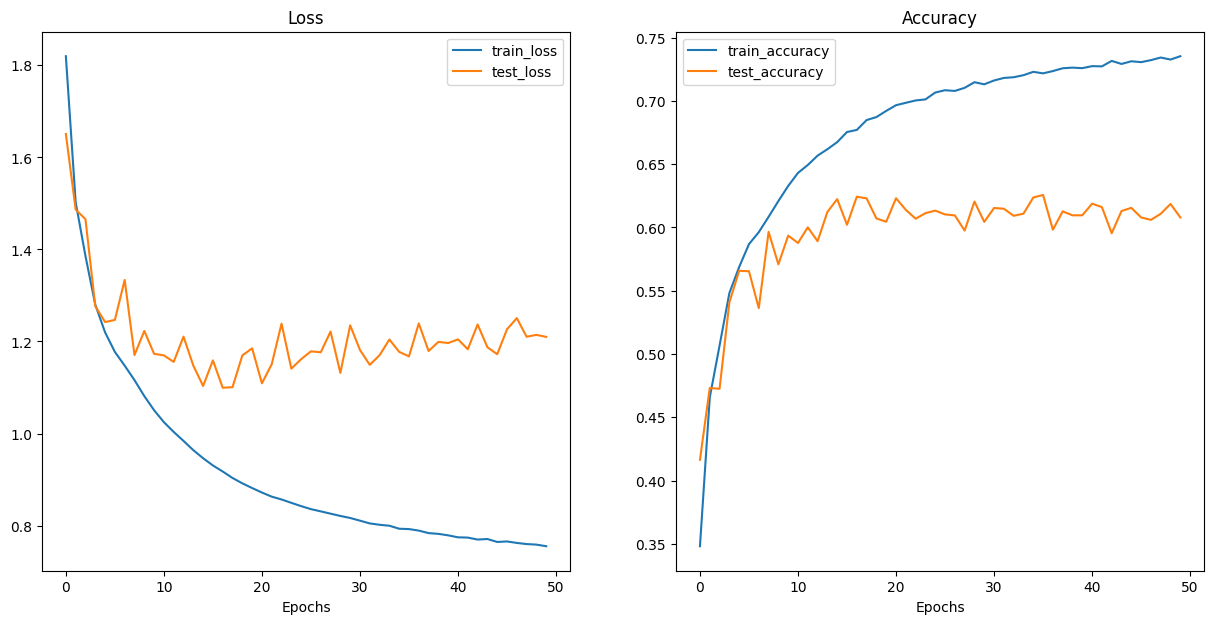

In [ ]:
plot_loss_curves(results4)

In [ ]:
def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power( 1 - (epoch) / MAX_EPOCHES ,power),8)

In [ ]:
def train_new(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          lr,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        adjust_learning_rate(optimizer, epoch, epochs, lr)
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=CNN(3,10,len(train_data.classes)).to(device)
from timeit import default_timer as timer
import numpy as np
start_time = timer()
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
lr=0.1
loss_fn=nn.CrossEntropyLoss()
results5=train_new(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              50,0.1,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7249 | train_acc: 0.3788 | test_loss: 1.4357 | test_acc: 0.4824
Epoch: 2 | train_loss: 1.3486 | train_acc: 0.5268 | test_loss: 1.3545 | test_acc: 0.5314
Epoch: 3 | train_loss: 1.2225 | train_acc: 0.5705 | test_loss: 1.4961 | test_acc: 0.4618
Epoch: 4 | train_loss: 1.1620 | train_acc: 0.5913 | test_loss: 1.2239 | test_acc: 0.5721
Epoch: 5 | train_loss: 1.1169 | train_acc: 0.6107 | test_loss: 1.3164 | test_acc: 0.5510
Epoch: 6 | train_loss: 1.0801 | train_acc: 0.6238 | test_loss: 1.2759 | test_acc: 0.5531
Epoch: 7 | train_loss: 1.0491 | train_acc: 0.6324 | test_loss: 1.2206 | test_acc: 0.5864
Epoch: 8 | train_loss: 1.0279 | train_acc: 0.6403 | test_loss: 1.1876 | test_acc: 0.5947
Epoch: 9 | train_loss: 1.0111 | train_acc: 0.6481 | test_loss: 1.2569 | test_acc: 0.5609
Epoch: 10 | train_loss: 1.0001 | train_acc: 0.6510 | test_loss: 1.2707 | test_acc: 0.5712
Epoch: 11 | train_loss: 0.9808 | train_acc: 0.6565 | test_loss: 1.1756 | test_acc: 0.6046
Epoch: 12 | train_l

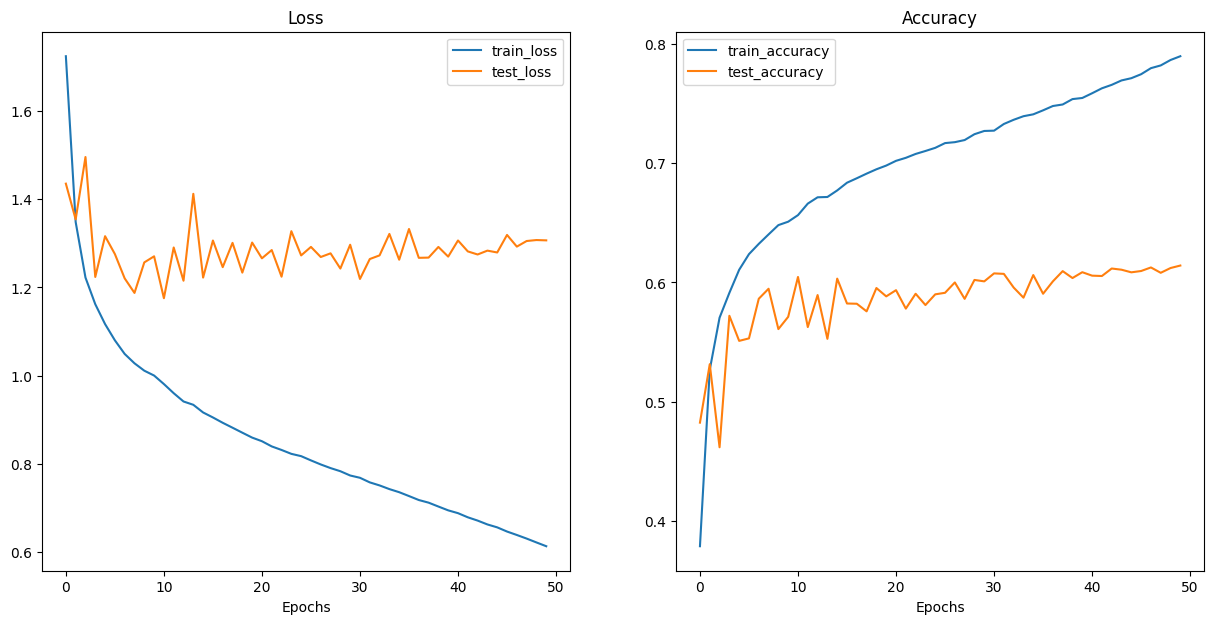

In [ ]:
plot_loss_curves(results5)

In [ ]:
from timeit import default_timer as timer
import numpy as np
device ="cuda" if torch.cuda.is_available() else "cpu"
model0=CNN(3,10,len(train_data.classes)).to(device)
start_time = timer()
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
lr=0.1
loss_fn=nn.CrossEntropyLoss()
results6=train_new(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              100,0.1,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7254 | train_acc: 0.3811 | test_loss: 1.4628 | test_acc: 0.4868
Epoch: 2 | train_loss: 1.3623 | train_acc: 0.5197 | test_loss: 1.5427 | test_acc: 0.4639
Epoch: 3 | train_loss: 1.2382 | train_acc: 0.5702 | test_loss: 1.2934 | test_acc: 0.5552
Epoch: 4 | train_loss: 1.1543 | train_acc: 0.5984 | test_loss: 1.4359 | test_acc: 0.5145
Epoch: 5 | train_loss: 1.1034 | train_acc: 0.6172 | test_loss: 1.2653 | test_acc: 0.5712
Epoch: 6 | train_loss: 1.0664 | train_acc: 0.6307 | test_loss: 1.3140 | test_acc: 0.5596
Epoch: 7 | train_loss: 1.0415 | train_acc: 0.6402 | test_loss: 1.2321 | test_acc: 0.5711
Epoch: 8 | train_loss: 1.0154 | train_acc: 0.6485 | test_loss: 1.2402 | test_acc: 0.5850
Epoch: 9 | train_loss: 0.9962 | train_acc: 0.6530 | test_loss: 1.2262 | test_acc: 0.5894
Epoch: 10 | train_loss: 0.9853 | train_acc: 0.6584 | test_loss: 1.2693 | test_acc: 0.5778
Epoch: 11 | train_loss: 0.9725 | train_acc: 0.6617 | test_loss: 1.2328 | test_acc: 0.5967
Epoch: 12 | train_l

In [ ]:
start_time = timer()
optimizer=torch.optim.SGD(model0.parameters(),lr=0.1)
lr=0.1
loss_fn=nn.CrossEntropyLoss()
results6=train_new(model0,train_dataloader,test_dataloader,optimizer,loss_fn,
              200,0.1,device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9823 | train_acc: 0.6560 | test_loss: 1.5248 | test_acc: 0.5280
Epoch: 2 | train_loss: 0.9435 | train_acc: 0.6671 | test_loss: 1.7282 | test_acc: 0.4891
Epoch: 3 | train_loss: 0.9253 | train_acc: 0.6745 | test_loss: 1.5944 | test_acc: 0.4937
Epoch: 4 | train_loss: 0.9156 | train_acc: 0.6763 | test_loss: 1.3827 | test_acc: 0.5680
Epoch: 5 | train_loss: 0.9149 | train_acc: 0.6790 | test_loss: 1.3981 | test_acc: 0.5668
Epoch: 6 | train_loss: 0.9057 | train_acc: 0.6812 | test_loss: 1.7688 | test_acc: 0.5342
Epoch: 7 | train_loss: 0.9006 | train_acc: 0.6836 | test_loss: 1.4752 | test_acc: 0.5542
Epoch: 8 | train_loss: 0.8970 | train_acc: 0.6882 | test_loss: 1.4591 | test_acc: 0.5498
Epoch: 9 | train_loss: 0.8990 | train_acc: 0.6863 | test_loss: 1.3830 | test_acc: 0.5683
Epoch: 10 | train_loss: 0.8918 | train_acc: 0.6861 | test_loss: 1.4923 | test_acc: 0.5273
Epoch: 11 | train_loss: 0.8951 | train_acc: 0.6879 | test_loss: 1.4632 | test_acc: 0.5610
Epoch: 12 | train_l

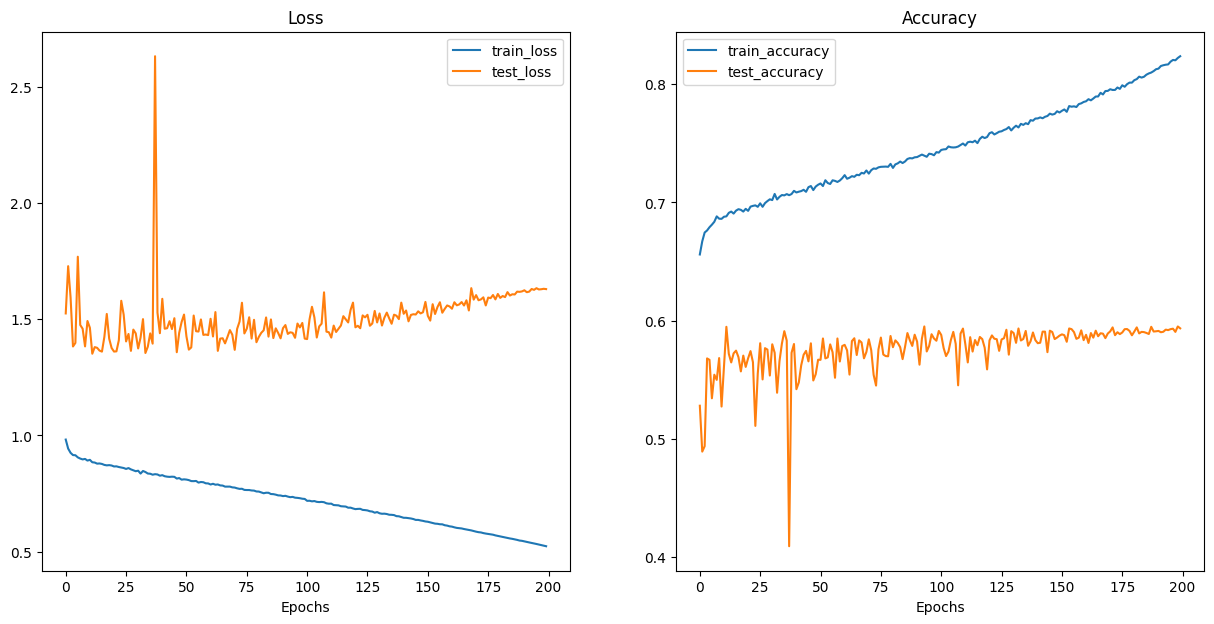

In [ ]:
plot_loss_curves(results6)